# Example Usage

In [1]:
%matplotlib inline
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from IPython.display import display
from elections import models as election_models
from parliaments import models as parliament_models
from proceedings import models as proceeding_models
from django_extensions.db.fields.json import JSONDict
from collections import OrderedDict
from federal_common.sources import EN, FR
from django.db.models.base import ModelBase
from IPython.display import HTML
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import os

def columns_reorder_left(dataframe, columns):
    unmentioned = [column for column in dataframe.columns if column not in columns]
    dataframe = dataframe[columns + unmentioned]
    return dataframe

def columns_reorder_after(dataframe, pairs):
    columns = list(dataframe.columns)
    for left, right in pairs.items():
        columns.remove(right)
        columns.insert(columns.index(left) + 1, right)
    return dataframe[columns]

dataframe_json_mapper = {
    "government_party": "Library of Parliament, History of Federal Ridings",
    "party": "Library of Parliament, History of Federal Ridings",
    "province": "Library of Parliament, Province / Territory File",
    "riding": "Library of Parliament, History of Federal Ridings",
    "parliamentarian": "Library of Parliament, Parliament File",
}

def get_dataframe(qs, mapping, index=None):
    mapping = OrderedDict(mapping)
    qs = qs.objects.all() if isinstance(qs, ModelBase) else qs
    dataframe = pd.DataFrame(
        {
            k: v.get(EN, {}).get(dataframe_json_mapper[k.split("__")[-2]], "") if isinstance(v, dict) else v
            for k, v in row_dict.items()
        }
        for row_dict in qs.values(*[
            key[0] if isinstance(key, tuple) else key
            for key in mapping.keys()
        ])
    )
    dataframe = columns_reorder_left(dataframe, list(mapping.keys()))
    dataframe.rename(columns=mapping, inplace=True)
    if index:
        dataframe = dataframe.set_index(index)
    dataframe = dataframe.sort_index()
    return dataframe

def select_by_index(dataframe, indexes):
    indexer = [slice(None)] * len(dataframe.index.names)
    for key, value in indexes.items():
        indexer[dataframe.index.names.index(key)] = value
    if len(indexer) > 1:
        return dataframe.loc[tuple(indexer), :]
    else:
        return dataframe.loc[tuple(indexer)]

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes."""
    # calculate evenly-spaced axis angles
    theta = 2 * np.pi * np.linspace(0, 1 - 1. / num_vars, num_vars)
    # rotate theta such that the first axis is at the top
    theta += np.pi / 2

    def draw_poly_frame(self, x0, y0, r):
        # TODO: use transforms to convert (x, y) to (r, theta)
        verts = [(r * np.cos(t) + x0, r * np.sin(t) + y0) for t in theta]
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_frame(self, x0, y0, r):
        return plt.Circle((x0, y0), r)

    frame_dict = {'polygon': draw_poly_frame, 'circle': draw_circle_frame}
    if frame not in frame_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):
        """Class for creating a radar chart (a.k.a. a spider or star chart)
        http://en.wikipedia.org/wiki/Radar_chart
        """
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_frame = frame_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180 / np.pi, labels)

        def _gen_axes_patch(self):
            x0, y0 = (0.5, 0.5)
            r = 0.5
            return self.draw_frame(x0, y0, r)

    register_projection(RadarAxes)
    return theta

def display_toggler(button="Click to toggle"):
    return HTML("""
        <script>
            function toggle_cell(event) {{
                $(event ? event.target : ".toggler")
                    .parents(".output_wrapper")
                    .prev()
                    .toggle(event ? undefined : false)
            }}
            $(document).ready(setTimeout(toggle_cell, 0))
        </script>
        <p><button class="toggler" onClick="javascript:toggle_cell(event)">{}</button></p>
    """.format(button))

display_toggler("Click to toggle the display the initializing scripts")

In [2]:
elections = get_dataframe(election_models.GeneralElection, {
    "number": "Election",
    "date": "Date",
    "population": "Population",
    "registered": "Registered",
    "ballots_total": "Ballots (Total)",
    "parliament__seats": "Seats",
    "parliament__government_party__names": "Party",
}, ["Election"])
elections['Date'] = pd.to_datetime(elections['Date'])  # TODO: Why isn't this happening automatically?
ridings = get_dataframe(election_models.ElectionRiding.objects.filter(general_election__isnull=False), {
    "general_election__number": "Election",
    "general_election__date": "Election: Date",
    "riding__province__names": "Province",
    "riding__names": "Riding",
    "population": "Population",
    "registered": "Registered",
    "ballots_rejected": "Ballots (Rejected)"
}, ["Election", "Province", "Riding"])
ridings['Election: Date'] = pd.to_datetime(ridings['Election: Date'])
candidates = get_dataframe(election_models.ElectionCandidate.objects.filter(election_riding__general_election__isnull=False), {
    "election_riding__general_election__number": "Election",
    "election_riding__general_election__date": "Election: Date",
    "election_riding__riding__province__names": "Province",
    "election_riding__riding__names": "Riding",
    "name": "Candidate",
    "party__names": "Party",
    "party__color": "Party: Color",
    "election_riding__population": "Riding: Population",
    "election_riding__registered": "Riding: Registered",
    "ballots": "Ballots",
    "elected": "Elected",
    "acclaimed": "Acclaimed",
}, ["Election", "Province", "Riding", "Candidate"])
candidates['Election: Date'] = pd.to_datetime(candidates['Election: Date'])
house_vote_participants = get_dataframe(proceeding_models.HouseVoteParticipant.objects.all(), {
    "house_vote__sitting__session__parliament__number": "Parliament",
    "house_vote__sitting__session__number": "Session",
    "house_vote__sitting__number": "Sitting",
    "house_vote__number": "Vote",
    "party__names": "Party",
    "parliamentarian__names": "Parliamentarian",
    "recorded_vote": "Parliamentarian: Vote",
}, ["Parliament", "Session", "Sitting", "Vote", "Party", "Parliamentarian"])
house_vote_participants = house_vote_participants.reset_index().fillna("Independent").set_index(house_vote_participants.index.names)

# Some ridings historically had two seats (Halifax, Victoria, etc). For the purposes of
# calculating voter turnout, we need to define a fractional ballot where a voter's single
# ballot is split in half between two candidates.
ridings = ridings.join(candidates[candidates["Elected"] | candidates["Acclaimed"]].reset_index().groupby(ridings.index.names)["Candidate"].count().to_frame())
ridings = ridings.rename(columns={"Candidate": "Seats"})
candidates = candidates.reset_index().set_index(ridings.index.names).join(ridings["Seats"]).reset_index().set_index(candidates.index.names)
candidates["Ballots (Fractional)"] = candidates["Ballots"] / candidates["Seats"]
del candidates["Seats"]

parties = candidates.reset_index().groupby(["Election", "Party"]).agg({
    "Election: Date": "first",
    'Candidate': 'count',
    'Ballots (Fractional)': 'sum',
    'Elected': 'sum',
    'Acclaimed': 'sum',
    'Party: Color': 'first',
}).rename(columns={
    'Candidate': 'Candidates',
    'Ballots (Fractional)': 'Ballots',
    "Party: Color": "Color",
})
parties["Seats"] = parties["Elected"] + parties["Acclaimed"]
del parties["Elected"]
del parties["Acclaimed"]

# Augment elections with winning party data
elections = elections.reset_index().set_index(parties.index.names).join(parties, rsuffix=" (Party)").reset_index().set_index(elections.index.names).rename(columns={
    'Candidates': 'Party: Candidates',
    'Ballots': 'Party: Ballots',
    'Color': 'Party: Color',
    'Seats (Party)': "Party: Seats",
})
del elections["Election: Date"]
elections = columns_reorder_after(elections, {
    "Seats": "Party",
})

# Copy valid ballots per candidate up to the ridings level
ridings = ridings.join(candidates.reset_index().groupby(ridings.index.names)["Ballots (Fractional)"].sum().to_frame())
ridings = ridings.rename(columns={"Ballots (Fractional)": "Ballots (Valid)"})
ridings = columns_reorder_after(ridings, {"Ballots (Valid)": "Ballots (Rejected)"})

# Copy winning candidate up to the ridings level
ridings_winning_parties = candidates[candidates["Elected"] == True].reset_index().set_index(ridings.index.names)
ridings = ridings.join(ridings_winning_parties[["Candidate", "Party", "Party: Color", "Ballots"]])
ridings = ridings.rename(columns={
    "Candidate": "Elected: Name",
    "Ballots": "Elected: Ballots",
    "Party": "Elected: Party",
    "Color": "Elected: Color",
})

# Copy valid ballots per riding back down to the ridings level
candidates = candidates.reset_index().set_index(ridings.index.names).join(
    ridings.reset_index().groupby(ridings.index.names).agg({"Ballots (Valid)": "first"})
).reset_index().set_index(candidates.index.names)
candidates = columns_reorder_after(candidates, {"Riding: Registered": "Ballots (Valid)"})
candidates = candidates.rename(columns={
    "Ballots (Valid)": "Riding: Ballots (Valid)",
})

# Copy valid ballots per riding up to the elections level
elections_ballot_sums = ridings.reset_index().groupby(ridings.index.names).agg({"Ballots (Valid)": "first"}).reset_index().groupby(["Election"])["Ballots (Valid)"].sum().to_frame()
elections = elections.join(elections_ballot_sums)
elections = columns_reorder_after(elections, {"Ballots (Total)": "Ballots (Valid)"})

# Augment parties with election level data
elections["Party: Ballot %"] = elections["Party: Ballots"] / elections["Ballots (Valid)"]
elections["Party: Seat %"] = elections["Party: Seats"] / elections["Seats"]
parties["Seat %"] = parties["Seats"] / elections["Seats"]
parties["Vote %"] = parties["Ballots"] / elections["Ballots (Valid)"]
parties["Seat % - Vote %"] = parties["Seat %"] - parties["Vote %"]
parties["Seat % / Vote %"] = parties["Seat %"] / parties["Vote %"]
candidates["Ballot %"] = candidates["Ballots"] / candidates["Riding: Ballots (Valid)"]

display_toggler("Click to toggle the display the data initialization")

## Raw data

Note that there are some hiccups in the raw data one might not expect.

* Until the 28th general election of 1968, ridings were sometimes represented by two MPs (e.g. Halifax). These were later split into multiple ridings.
* Until the 24th general election of 1958, some candidates won by acclaimation, not by election (e.g. Lionel Bertrand). That is to say, they ran unopposed and therefore had no ballots cast in their favour.

These peculiarities should be kept in mind when generating aggregate statistics. For simplicity, let's define "_28plus" suffixed dataframes.

In [3]:
elections["Registered / Population"] = elections["Registered"] / elections["Population"]
elections["Ballots / Population"] = elections["Ballots (Valid)"] / elections["Population"]
elections["Ballots / Registered"] = elections["Ballots (Valid)"] / elections["Registered"]

elections_28plus = select_by_index(elections, {"Election": slice(28, None)})
candidates_28plus = select_by_index(candidates, {"Election": slice(28, None)})
parties_28plus = select_by_index(parties, {"Election": slice(28, None)})
ridings_28plus = select_by_index(ridings, {"Election": slice(28, None)})
del candidates_28plus["Acclaimed"]
del candidates_28plus["Ballots (Fractional)"]
del ridings_28plus["Seats"]

### Elections

In [4]:
display(elections.tail(5))

,Date,Population,Registered,Ballots (Total),Ballots (Valid),Seats,Party,Party: Candidates,Party: Ballots,Party: Color,Party: Seats,Party: Ballot %,Party: Seat %,Registered / Population,Ballots / Population,Ballots / Registered
Election,,,,,,,,,,,,,,,,
38,2004-06-28,30007094,22466621,13683570,13564702.0,308,Liberal,308,4982220.0,#EA6D6A,135.0,0.367293,0.438312,0.748710,0.452050,0.603771
39,2006-01-23,30007094,23054615,14908703,14817159.0,308,Conservative Party of Canada,308,5374071.0,#6495ED,124.0,0.362692,0.402597,0.768305,0.493789,0.642698
40,2008-10-14,31612897,23677639,13929093,13834294.0,308,Conservative Party of Canada,307,5209069.0,#6495ED,143.0,0.376533,0.464286,0.748987,0.437616,0.584277
41,2011-05-02,33476688,24257592,14823408,14723980.0,308,Conservative Party of Canada,307,5835270.0,#6495ED,166.0,0.396311,0.538961,0.724611,0.439828,0.606984
42,2015-10-19,33476688,25939742,17711983,17591468.0,338,Liberal,338,6942937.0,#EA6D6A,184.0,0.394676,0.544379,0.774860,0.525484,0.678167


### Ridings

In [5]:
display(select_by_index(ridings, {"Riding": ["HALIFAX"], "Election": [*range(40, 42 + 1)]}))

,,,Election: Date,Population,Registered,Seats,Ballots (Valid),Ballots (Rejected),Elected: Name,Elected: Party,Party: Color,Elected: Ballots
Election,Province,Riding,,,,,,,,,,
40,Nova Scotia,HALIFAX,2008-10-14,89448.0,74717.0,1,45098.0,230.0,"LESLIE, Megan",New Democratic Party,#F4A460,19252.0
41,Nova Scotia,HALIFAX,2011-05-02,89448.0,73357.0,1,45987.0,241.0,"LESLIE, Megan",New Democratic Party,#F4A460,23746.0
42,Nova Scotia,HALIFAX,2015-10-19,92643.0,73379.0,1,53032.0,259.0,"FILLMORE, Andy",Liberal,#EA6D6A,27431.0


### Candidates

In [6]:
display(select_by_index(candidates[candidates["Ballot %"] > .01], {
    "Election": [42],
    "Riding": ["VANCOUVER QUADRA"],
}))

Election: Date  \
Election Province         Riding           Candidate                        
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott      2015-10-19   
                                           CONSTABLE, Kris     2015-10-19   
                                           LOCKHART, Blair     2015-10-19   
                                           MURRAY, Joyce       2015-10-19   

                                                                                   Party  \
Election Province         Riding           Candidate                                       
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott           New Democratic Party   
                                           CONSTABLE, Kris         Green Party of Canada   
                                           LOCKHART, Blair  Conservative Party of Canada   
                                           MURRAY, Joyce                         Liberal   

                                                           Party: Color  \
Election Province         Riding           Candidate                      
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott       #F4A460   
                                           CONSTABLE, Kris      #99C955   
                                           LOCKHART, Blair      #6495ED   
                                           MURRAY, Joyce        #EA6D6A   

                                                            Riding: Population  \
Election Province         Riding           Candidate                             
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott             102416.0   
                                           CONSTABLE, Kris            102416.0   
                                           LOCKHART, Blair            102416.0   
                                           MURRAY, Joyce              102416.0   

                                                            Riding: Registered  \
Election Province         Riding           Candidate                             
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott              76038.0   
                                           CONSTABLE, Kris             76038.0   
                                           LOCKHART, Blair             76038.0   
                                           MURRAY, Joyce               76038.0   

                                                            Riding: Ballots (Valid)  \
Election Province         Riding           Candidate                                  
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott                   52972.0   
                                           CONSTABLE, Kris                  52972.0   
                                           LOCKHART, Blair                  52972.0   
                                           MURRAY, Joyce                    52972.0   

                                                            Ballots  Elected  \
Election Province         Riding           Candidate                           
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott    5748.0    False   
                                           CONSTABLE, Kris   2229.0    False   
                                           LOCKHART, Blair  13683.0    False   
                                           MURRAY, Joyce    31102.0     True   

                                                            Acclaimed  \
Election Province         Riding           Candidate                    
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott       False   
                                           CONSTABLE, Kris      False   
                                           LOCKHART, Blair      False   
                                           MURRAY, Joyce        False   

                                                            Ballots (Fractional)  \
Election Province         Riding           Candidate                           

### Parties

In [7]:
display(select_by_index(
    parties[parties["Seats"] > 0],
    {"Election": [42]},
))

Election: Date  Candidates    Ballots  \
Election Party                                                                
42       Bloc Québécois                   2015-10-19          78   821144.0   
         Conservative Party of Canada     2015-10-19         338  5613633.0   
         Green Party of Canada            2015-10-19         336   602933.0   
         Liberal                          2015-10-19         338  6942937.0   
         New Democratic Party             2015-10-19         338  3469368.0   

                                         Color  Seats    Seat %    Vote %  \
Election Party                                                              
42       Bloc Québécois                #87CEFA   10.0  0.029586  0.046679   
         Conservative Party of Canada  #6495ED   99.0  0.292899  0.319111   
         Green Party of Canada         #99C955    1.0  0.002959  0.034274   
         Liberal                       #EA6D6A  184.0  0.544379  0.394676   
         New Democratic Party          #F4A460   44.0  0.130178  0.197219   

                                       Seat % - Vote %  Seat % / Vote %  
Election Party                                                           
42       Bloc Québécois                      -0.017093         0.633820  
         Conservative Party of Canada        -0.026212         0.917860  
         Green Party of Canada               -0.031316         0.086321  
         Liberal                              0.149702         1.379304  
         New Democratic Party                -0.067041         0.660066

### Other data types

A fair amount of further data is stored in this dataset. Photos for MPs, links to Wikipedia pages, bill titles, etc. If there's more data you'd like to see, send me an email at bradbeattie@gmail.com.

In [8]:
for models in parliament_models, election_models, proceeding_models:
    print(", ".join(sorted(
        str(getattr(models, model_name)._meta.verbose_name_plural.title())
        for model_name in dir(models)
        if isinstance(getattr(models, model_name), ModelBase)
        and not getattr(models, model_name)._meta.abstract
    )))

Parliamentarians, Parliaments, Parties, Provinces, Ridings, Sessions
By Elections, Election Candidates, Election Ridings, General Elections
Bills, Committees, Hansard Blocks, House Vote Participants, House Votes, Recordings, Sittings


## Is there a clear relation between popular vote and disproportionality?

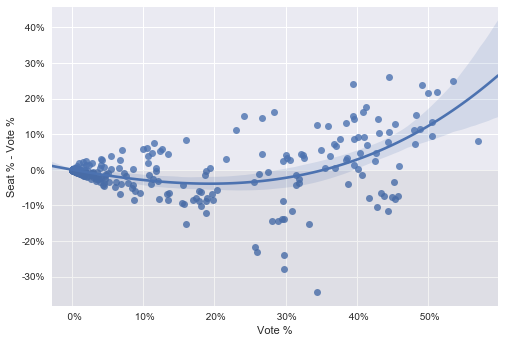

In [9]:
df = parties
df = df.reset_index()
df = df[(df["Party"] != "Independent")]
g = sns.regplot(x="Vote %", y="Seat % - Vote %", data=df, order=3)
g.add_patch(patches.Rectangle((-1, -1), 2, 1, alpha=0.05, facecolor="black"))
g.set_xticklabels(['{:3.0f}%'.format(x * 100) for x in g.get_xticks()])
g.set_yticklabels(['{:3.0f}%'.format(y * 100) for y in g.get_yticks()]);

## How has the registered voting population and voter turnout changed over time?

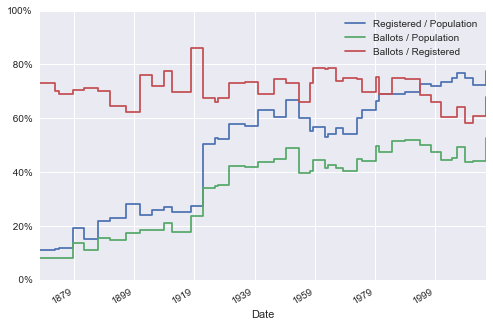

In [10]:
df = elections
plot = df.plot(x="Date", y=[
    "Registered / Population",
    "Ballots / Population",
    "Ballots / Registered",
], drawstyle="steps-post")
plot.set(ylim=(0, 1));
plot.set_yticklabels(['{:3.0f}%'.format(y * 100) for y in plot.get_yticks()]);

## Which parties have held power and which majorities have been false?

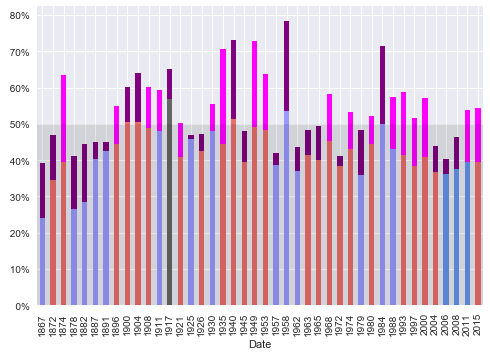

In [11]:
df = elections
df["Kind"] = np.where(df["Party: Seat %"] < 0.5, "minority", np.where(df["Party: Ballot %"] < 0.5, "false majority", "majority"))
kind_colors = { "minority": "purple", "majority": "purple", "false majority": "magenta"}
df["Party: Seat % - Ballot %"] = df["Party: Seat %"] - df["Party: Ballot %"]
plot = df.plot(
    x=df["Date"].dt.year,
    y=['Party: Ballot %', 'Party: Seat % - Ballot %'],
    kind='bar',
    legend=False,
    stacked=True,
    color=[
        list(df["Party: Color"]),
        [kind_colors.get(kind) for kind in df["Kind"]]
    ],
)

plot.set_yticklabels(['{:3.0f}%'.format(y * 100) for y in plot.get_yticks()]);
plot.add_patch(patches.Rectangle((-1, -1), len(df) + 1, 1.5, alpha=0.1, facecolor="black"));

## Do ridings with more registered voters prefer certain parties?

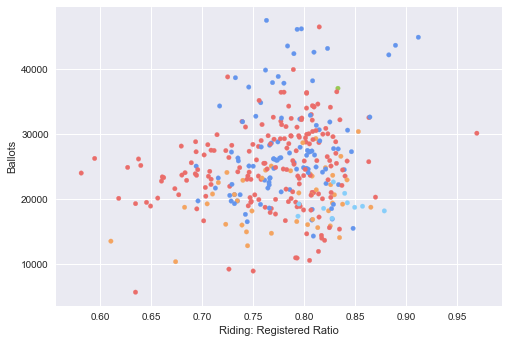

In [12]:
df = select_by_index(candidates, {"Election": 42})
df = df[df["Elected"]]
df["Riding: Registered Ratio"] = df["Riding: Registered"] / df["Riding: Population"]
plot = df.plot(kind="scatter", x="Riding: Registered Ratio", y="Ballots", c=df["Party: Color"]);

## How much overlap is there in winning ballot percentages per party?

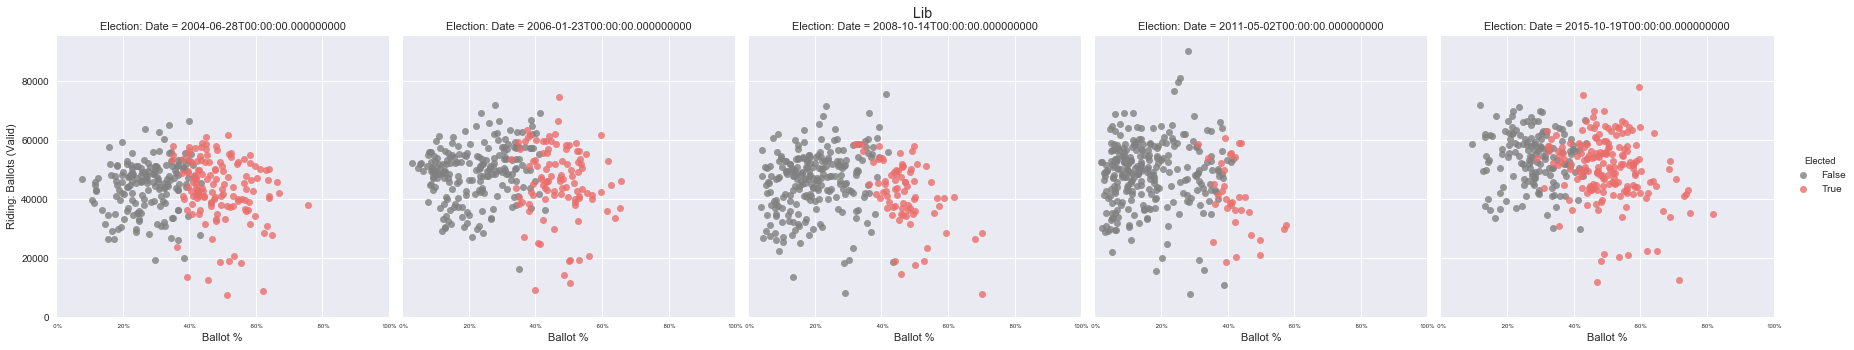

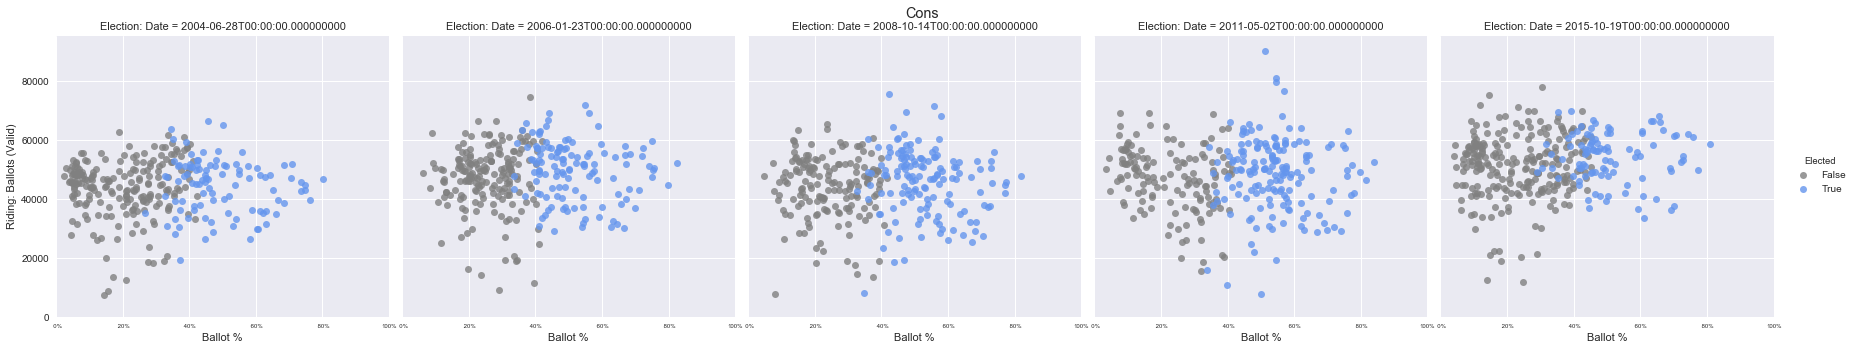

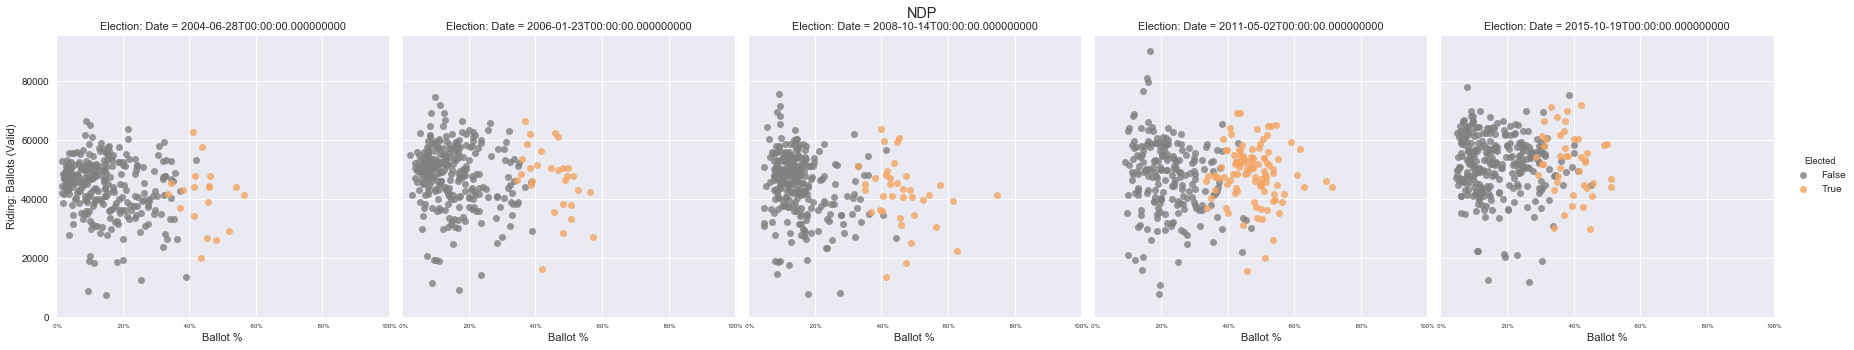

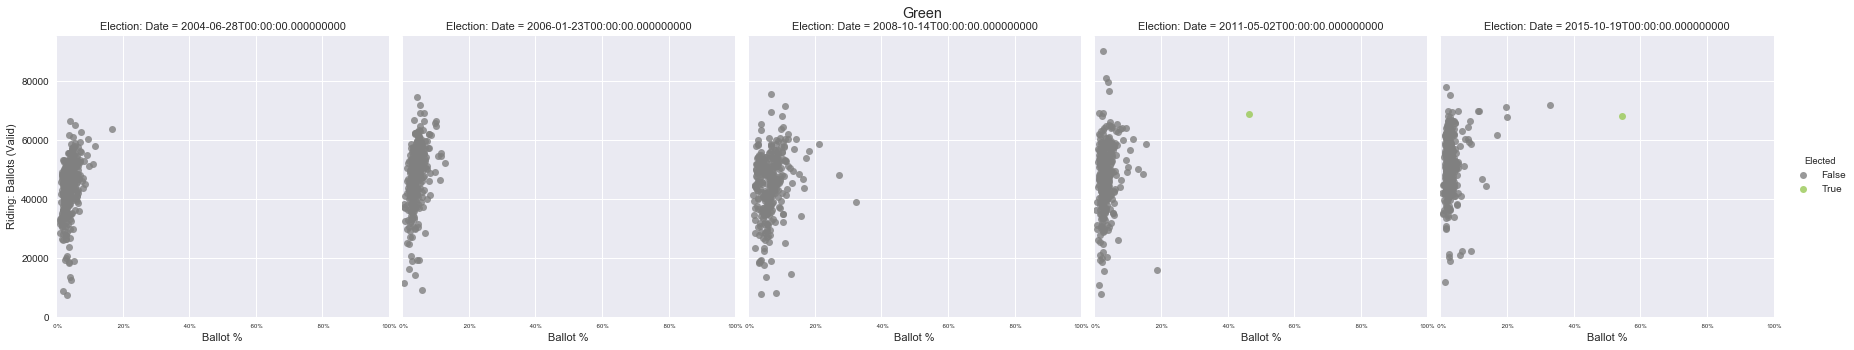

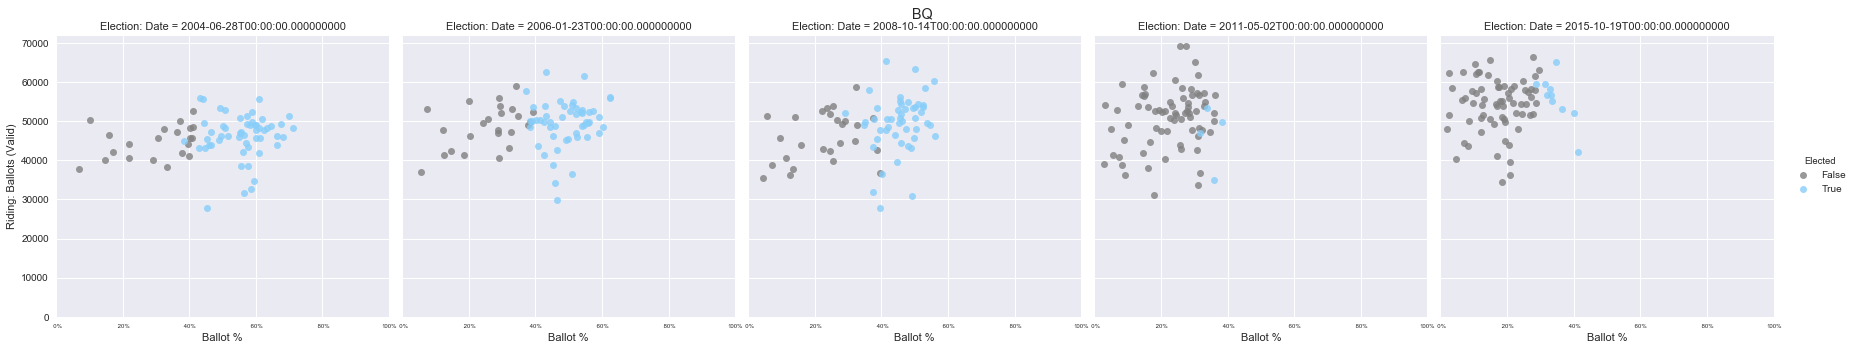

In [13]:
from_year = 2000
df = select_by_index(candidates, {"Election": [*range(38, 42 + 1)]})
dfilters = (
    ("Lib", df["Party"] == "Liberal"),
    ("Cons", df["Party"] == "Conservative Party of Canada"),
    ("NDP", df["Party"] == "New Democratic Party"),
    ("Green", df["Party"] == "Green Party of Canada"),
    ("BQ", df["Party"] == "Bloc Québécois"),
)
for name, dfilter in dfilters:
    df2 = df[dfilter]
    sns.set_palette(sns.color_palette(["grey", df2[df2["Elected"] == True]["Party: Color"].iloc[-1]]))
    g = sns.lmplot(
        x="Ballot %",
        y="Riding: Ballots (Valid)",
        hue="Elected",
        col="Election: Date",
        data=df2,
        fit_reg=False,
    )
    g.set(ylim=(0, None))
    g.set(xlim=(0.0, 1.0))
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:3.0f}%'.format(x * 100)))
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(name)
    plt.show()